# Calibration Exercice - Solution

##  Author: 
- Troels Petersen ([email](mailto:petersen@nbi.dk))
- Étienne Bourbeau (notebook conversion) ([email](mailto:etienne.bourbeau@icecube.wisc.edu))

##  Date:   
20th of December 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# Set som plotting standards
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)

from iminuit import Minuit
from probfit import Chi2Regression, BinnedLH, UnbinnedLH
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [2]:
print(parent_folder(parent_folder(os.getcwd()))+'/External_Functions')

/home/jovyan/work/AppStat2018/External_Functions


In [3]:
sys.path.append(parent_folder(parent_folder(os.getcwd()))+'/External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax

In [4]:
verbose = True
Nverbose = 10
SaveFigures = False

### Define functions:

In [5]:
# Profile x of the two arrays x and y with defined number of bins and range
# returns the x-values of the profile, the means and the stds.
def profile_x(x, y, bins=(50, 50), xyrange=[(0, 50), (-1,1)]):
    
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=xyrange)
    x_center = 0.5*(xedges[1:] + xedges[:-1])
    y_center = 0.5*(yedges[1:] + yedges[:-1])
    
    wsums = H.sum(1)
    
    mask = wsums > 0
    
    mean = (H*y_center).sum(1)[mask] / wsums[mask]
    mean_squared = (H*y_center**2).sum(1)[mask] / wsums[mask]
    std = np.sqrt( mean_squared - mean**2 ) / np.sqrt(wsums[mask]) 

    return x_center[mask], mean, std


def parabola(x, p0, p1, p2):
    return p0 + p1*x + p2*x**2


def exponential(x, p0, p1, p2):
    return p0 + p1*np.exp(p2*x)


def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)


def gauss_extended(x, N, mu, sigma):
    """Non-normalized Gaussian"""
    return N * binwidth * gauss_pdf(x, mu, sigma)

### Harvesting Text file
We'll only use the short, numpy version here:

In [6]:
filename = "../../Week5/Calibration/data_calib.txt"
# the numpy way:
dknown, dmeas, lsig, lbkg, temp, tsky = np.loadtxt(filename, unpack=True)

---

#### __Let's plot the raw data to see what it looks like__

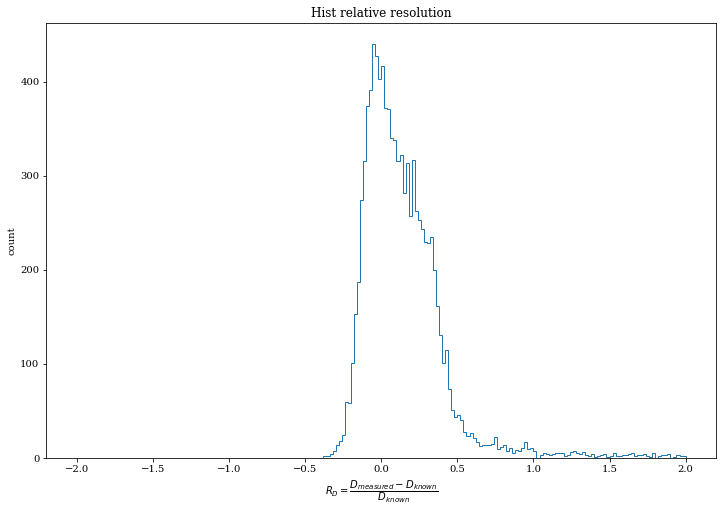

In [7]:
plt.ioff() # We use to hide the empty plot on this cell
fig_rel, ax_rel = plt.subplots(figsize=(12, 8));
ax_rel.set_title('Hist relative resolution');
Nbins = 200
xmin, xmax = -2,2
binwidth = (xmax-xmin) / Nbins


distrel = (dmeas - dknown) / dknown
ax_rel.hist(distrel, bins=Nbins, range=(xmin, xmax), histtype='step', label='Raw');
ax_rel.set_xlabel(r'$R_{D} = \dfrac{D_{measured}-D_{known}}{D_{known}}$')
ax_rel.set_ylabel('count')
fig_rel

#### __We can effectively see that the raw data is pretty bad, with a clearly non-gaussian shape, and a large tail toward positive values.Now let's plot $R_{D}$ as a function of all four variables:__

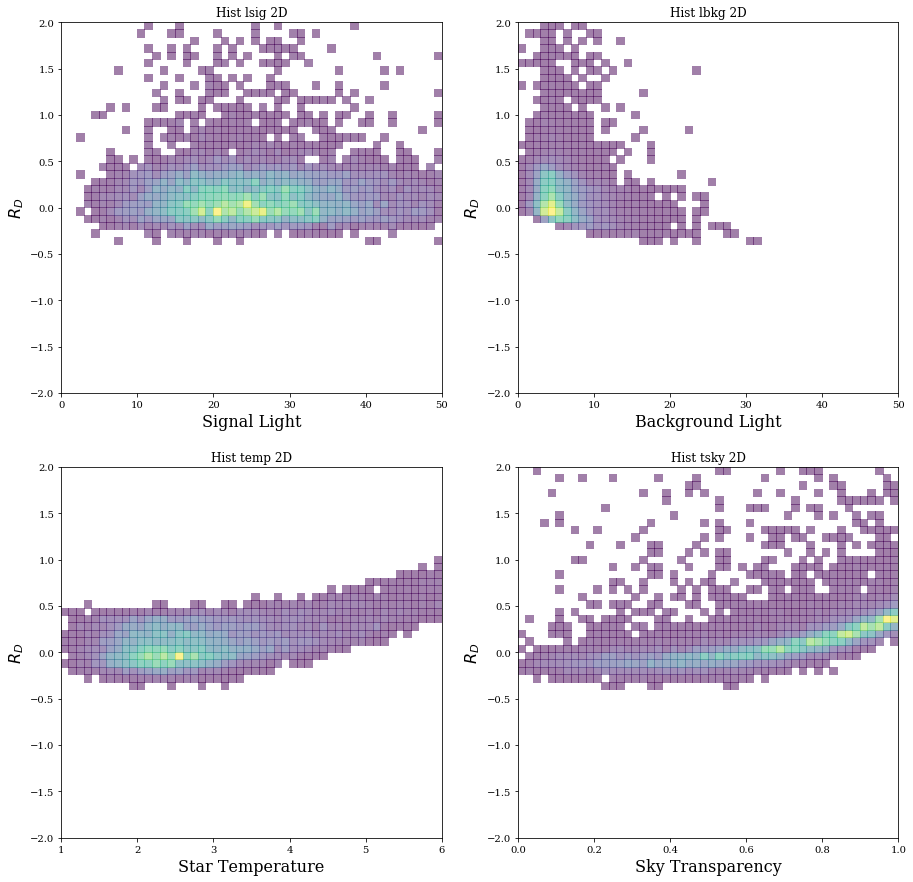

In [8]:
fig_2D, axes = plt.subplots(2,2,figsize=(15,15));

ax_lsig2D = axes[0,0]
ax_lbkg2D = axes[0,1]
ax_temp2D = axes[1,0]
ax_tsky2D = axes[1,1]

ax_lsig2D.set_title('Hist lsig 2D');
ax_lbkg2D.set_title('Hist lbkg 2D');
ax_temp2D.set_title('Hist temp 2D');
ax_tsky2D.set_title('Hist tsky 2D');

## Define a binning for all four variables
binning_RD   = (-2.,2.)
binning_lsig = (0, 50)
binning_lbkg = (0, 50)
binning_temp = (1, 6)
binning_tsky = (0, 1)

ax_lsig2D.hist2d(lsig, distrel, bins=50, range=[binning_lsig, binning_RD], cmin=1, alpha=0.5);
ax_lbkg2D.hist2d(lbkg, distrel, bins=50, range=[binning_lbkg, binning_RD], cmin=1, alpha=0.5);
ax_temp2D.hist2d(temp, distrel, bins=50, range=[binning_temp, binning_RD], cmin=1, alpha=0.5);
ax_tsky2D.hist2d(tsky, distrel, bins=50, range=[binning_tsky, binning_RD], cmin=1, alpha=0.5);

ax_lsig2D.set_ylabel(r'$R_{D}$',fontsize=16)
ax_lbkg2D.set_ylabel(r'$R_{D}$',fontsize=16)
ax_temp2D.set_ylabel(r'$R_{D}$',fontsize=16)
ax_tsky2D.set_ylabel(r'$R_{D}$',fontsize=16)

ax_lsig2D.set_xlabel(r'Signal Light',fontsize=16)
ax_lbkg2D.set_xlabel(r'Background Light',fontsize=16)
ax_temp2D.set_xlabel(r'Star Temperature',fontsize=16)
ax_tsky2D.set_xlabel(r'Sky Transparency',fontsize=16)

fig_2D

__As it was underlined in the exercice, there seems to be no large correlation between $R_{D}$ and the signal light from the data. There are however significant correlations between $R_{D}$ and the Sky Transparency, as well as with the Background light.__

---
### Fitting each variable with a functional trend

__We use a polynomial of degree 2 to model the trend in both `temp` and `lbkg`. For `tsky` we use a constant plus an exponential function.__


#### _Star Temperature `temp`_

First find the mean and standard deviation of each "slice" of $R_{D}$ distribution, for each central value of the `temp` bins:

In [9]:
x_center_temp2D, mean_temp2D, std_temp2D = profile_x(temp, distrel, bins=(50, 50), xyrange=[binning_temp, binning_RD])
x_binwidth_temp2D = x_center_temp2D[1] - x_center_temp2D[0]

ax_temp2D.errorbar(x_center_temp2D, mean_temp2D, xerr=x_binwidth_temp2D/2, yerr=std_temp2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1);


Perform the fit on the means and standard deviations found above:

In [10]:
# Note the use of the mask to fit only the data contained within the histogram range
mask = (1 < x_center_temp2D) & (x_center_temp2D < 6)

chi2_object = Chi2Regression(parabola, x_center_temp2D[mask], mean_temp2D[mask], std_temp2D[mask]) 

minuit = Minuit(chi2_object, pedantic=False, p0=1, p1=1, p2=1)  
minuit.migrad();  # perform the actual fit

print("temp:")
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
x_fit = np.linspace(0, 25, 1000) # Create the x-axis for the plot of the fitted function
y_fit = parabola(x_fit, *minuit.args) # the fitted function

ax_temp2D.plot(x_fit, y_fit, '-', color='green', lw=2,label='fit');


Chi2 = minuit.fval
ndof = len(x_center_temp2D[mask])-3
d = {'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2,ndof) ,
     'Prob'      : "{:.3f}".format(stats.chi2.sf(Chi2, ndof)),
     'p0'        : "{:.3f} +/- {:.3f}".format(minuit.values['p0'], minuit.errors['p0']),
     'p1'        : "{:.3f} +/- {:.3f}".format(minuit.values['p1'], minuit.errors['p1']),
     'p2'        : "{:.3f} +/- {:.3f}".format(minuit.values['p2'], minuit.errors['p2'])}

ax_temp2D.text(0.6, 0.2, nice_string_output(d, 0), family='monospace', 
               transform=ax_temp2D.transAxes, fontsize=9, color='k', verticalalignment='top');


temp_par = [minuit.values['p0'],minuit.values['p1'],minuit.values['p2']]

FCN = 44.294371979474775 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = 1.3240541372838363e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,p0,0.212012,0.0151015,,,,,No
1,p1,-0.158061,0.00967488,,,,,No
2,p2,0.0387662,0.0014373,,,,,No


temp:
Fit value: p0 = 0.21201 +/- 0.01510
Fit value: p1 = -0.15806 +/- 0.00967
Fit value: p2 = 0.03877 +/- 0.00144


### __Let's see if the fit works...__

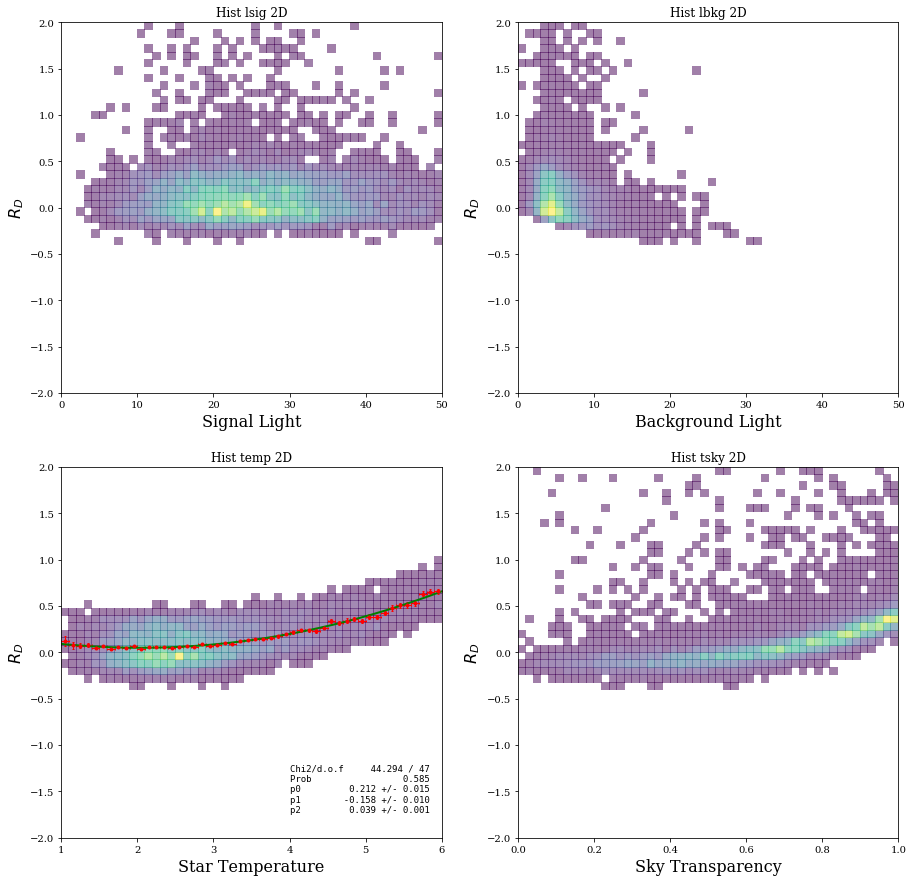

In [11]:
fig_2D

### __alright, it's not the best of fits but let's say it's good enough for now... Moving on to the Background light:__

Note that for distribution, a first look at the histogram by eye would make you think that an asymptotic function would be more appropriate than a polynomial (something like $Aln(x+b)$). However, if you plot the means and standard deviations of each distribution slice, you'll see a different trend emerge (this one, more compatible with the parabola).

In [12]:
x_center_lbkg2D, mean_lbkg2D, std_lbkg2D = profile_x(lbkg, distrel, bins=(50, 50), xyrange=[binning_lbkg, binning_RD])
x_binwidth_lbkg2D = x_center_lbkg2D[1] - x_center_lbkg2D[0]

ax_lbkg2D.errorbar(x_center_lbkg2D, mean_lbkg2D, xerr=x_binwidth_lbkg2D/2, yerr=std_lbkg2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1);

now the fit:

In [13]:
mask = (0 < x_center_lbkg2D) & (x_center_lbkg2D < 25) & ( std_lbkg2D > 0 )


chi2_object_bkg = Chi2Regression(parabola, x_center_lbkg2D[mask], mean_lbkg2D[mask], std_lbkg2D[mask]) 

minuit = Minuit(chi2_object_bkg, pedantic=False, p0=1, p1=1, p2=1)  
minuit.migrad()


print("lbkg:")

for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
x_fit = np.linspace(0, 25, 1000) # Create the x-axis for the plot of the fitted function
y_fit = parabola(x_fit, *minuit.args) # the fitted function

ax_lbkg2D.plot(x_fit, y_fit, '-', color='green', lw=2,label='fit');


Chi2 = minuit.fval
ndof = len(x_center_lbkg2D[mask])-3
d = {'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2,ndof) ,
     'Prob'      : "{:.3f}".format(stats.chi2.sf(Chi2, ndof)),
     'p0'        : "{:.3f} +/- {:.3f}".format(minuit.values['p0'], minuit.errors['p0']),
     'p1'        : "{:.3f} +/- {:.3f}".format(minuit.values['p1'], minuit.errors['p1']),
     'p2'        : "{:.3f} +/- {:.3f}".format(minuit.values['p2'], minuit.errors['p2'])}

ax_lbkg2D.text(0.6, 0.6, nice_string_output(d, 0), family='monospace', 
               transform=ax_lbkg2D.transAxes, fontsize=9, color='k', verticalalignment='top');

lbkg_par = [minuit.values['p0'],minuit.values['p1'],minuit.values['p2']]

FCN = 48.90221320185394 
 TOTAL NCALL = 68 
 NCALLS = 68 
 
 
 EDM = 1.0666133515151624e-13 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,p0,0.276422,0.00900731,,,,,No
1,p1,-0.0279625,0.00225325,,,,,No
2,p2,0.000609005,0.000111233,,,,,No


lbkg:
Fit value: p0 = 0.27642 +/- 0.00901
Fit value: p1 = -0.02796 +/- 0.00225
Fit value: p2 = 0.00061 +/- 0.00011


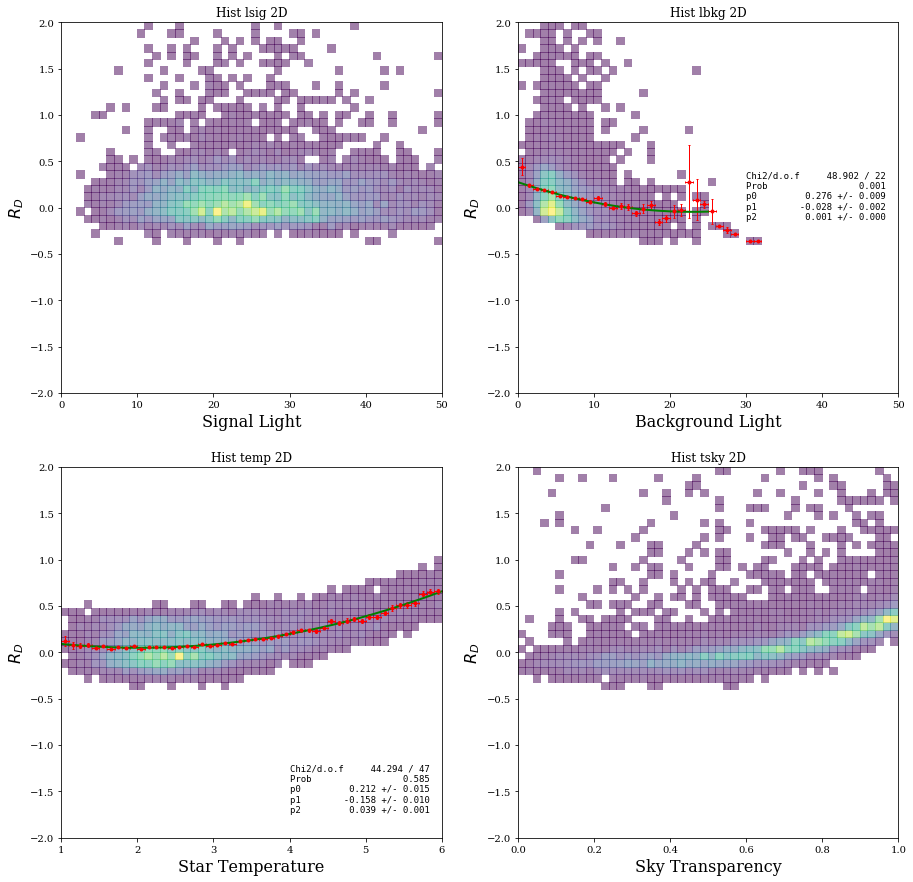

In [14]:
fig_2D

### __Moving on to the Sky Transparency:__

In [15]:
x_center_tsky2D, mean_tsky2D, std_tsky2D = profile_x(tsky, distrel, bins=(50, 50), xyrange=[binning_tsky, binning_RD])
x_binwidth_tsky2D = x_center_tsky2D[1] - x_center_tsky2D[0]

ax_tsky2D.errorbar(x_center_tsky2D, mean_tsky2D, xerr=x_binwidth_tsky2D/2, yerr=std_tsky2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1);


Fit the thing...

In [16]:
mask = (0 < x_center_tsky2D) & (x_center_tsky2D < 1)


chi2_object = Chi2Regression(exponential, x_center_tsky2D[mask], mean_tsky2D[mask], std_tsky2D[mask]) 

minuit = Minuit(chi2_object, pedantic=False, p0=-0.2, p1=0.02, p2=1.0)  
minuit.migrad()


print("tsky:")
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
x_fit = np.linspace(0, 1, 1000) # Create the x-axis for the plot of the fitted function
y_fit = exponential(x_fit, *minuit.args) # the fitted function
ax_tsky2D.plot(x_fit, y_fit, '-', color='green', lw=2,label='fit'); 


Chi2 = minuit.fval
ndof = len(x_center_tsky2D[mask])-3
d = {'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2,ndof) ,
     'Prob'      : "{:.3f}".format(stats.chi2.sf(Chi2, ndof)),
     'p0'        : "{:.3f} +/- {:.3f}".format(minuit.values['p0'], minuit.errors['p0']),
     'p1'        : "{:.3f} +/- {:.3f}".format(minuit.values['p1'], minuit.errors['p1']),
     'p2'        : "{:.3f} +/- {:.3f}".format(minuit.values['p2'], minuit.errors['p2'])}

ax_tsky2D.text(0.6, 0.2, nice_string_output(d, 0), family='monospace', 
               transform=ax_tsky2D.transAxes, fontsize=9, color='k', verticalalignment='top');

tsky_par = [minuit.values['p0'],minuit.values['p1'],minuit.values['p2']]

FCN = 85.65650140358419 
 TOTAL NCALL = 140 
 NCALLS = 140 
 
 
 EDM = 7.23162710442567e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,p0,-0.0967761,0.00911578,,,,,No
1,p1,0.0169609,0.00276975,,,,,No
2,p2,3.48168,0.155868,,,,,No


tsky:
Fit value: p0 = -0.09678 +/- 0.00912
Fit value: p1 = 0.01696 +/- 0.00277
Fit value: p2 = 3.48168 +/- 0.15587


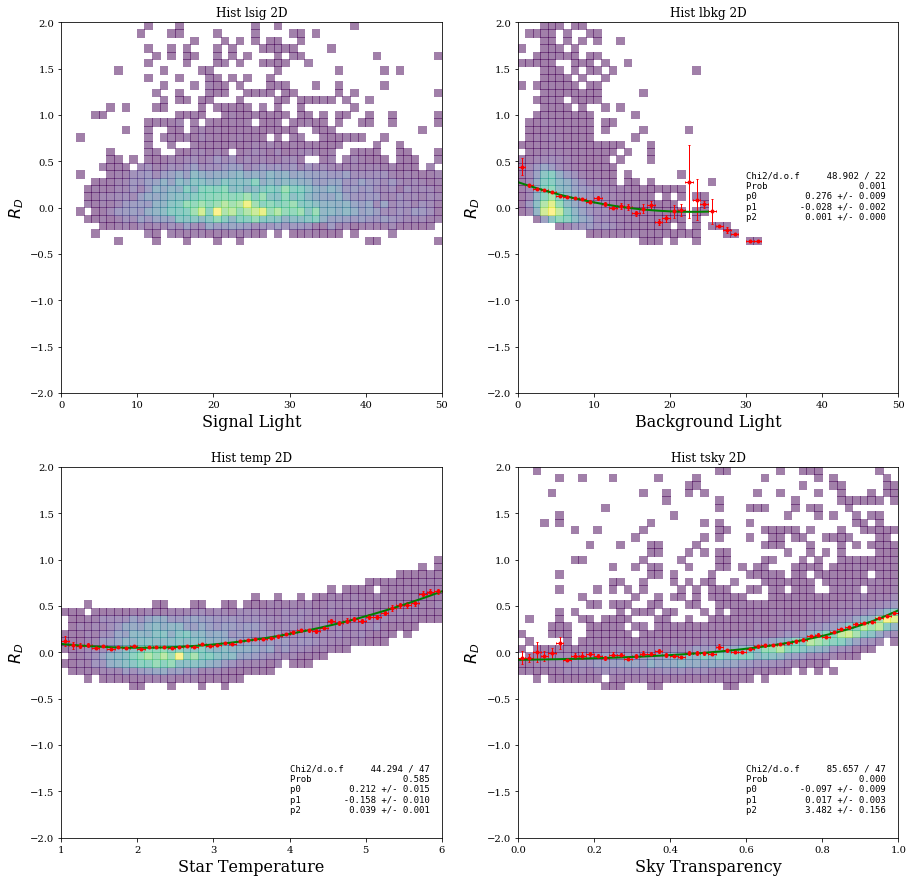

In [17]:
fig_2D

### __Now we have fitted trends on three parameters. Let's correct the raw data for these correlations:__

In [18]:
# Calibration constants:

""" Old calibration constant
temp_par = [ 0.11305,  -0.07761,  0.02325 ]   # Pol2
lbkg_par = [ 0.23035,  -0.02821,  0.00066 ]   # Pol2
tsky_par = [ -0.13056,  0.01952,  3.28562 ]   # Pol0 + Exp

# Calibration constants:
lbkg_par = [ 0.12694, -0.02465,  0.00047]   # Pol2
temp_par = [ 0.1847,  -0.1408,   0.0364]    # Pol2
tsky_par = [-0.20348,  0.01490,  3.49192]   # Pol0 + Exp
"""

""" Some other old constants
# Calibration constants:
lbkg_par = [ 0.26092,  -0.02913,  0.00067 ]   # Pol2
temp_par = [ 0.08598,  -0.14270,  0.03493 ]   # Pol2
tsky_par = [ -0.19774,  0.01273,  3.64826 ]   # Pol0 + Exp
""";

----
## Produce a calibrated data set

To do this, we associate a weight to each data point, based on the fitted functions above. The calibrated dataset is then computed as prescribed in the exercice:

 * $R_{D} = \frac{d - d_{true}}{d_{true}}  \rightarrow  d_{calib} = \frac{d}{(1 + f(x))}$

In [19]:
calib_temp = temp_par[0] + temp_par[1]*temp + temp_par[2]*temp**2
calib_lbkg = lbkg_par[0] + lbkg_par[1]*lbkg + lbkg_par[2]*lbkg**2
calib_tsky = tsky_par[0] + tsky_par[1]*np.exp(tsky_par[2]*tsky)

dmeas_calib = dmeas / (1.0 + calib_temp) / (1.0 + calib_lbkg) / (1.0 + calib_tsky)

With this we can plot the corrected distribution:

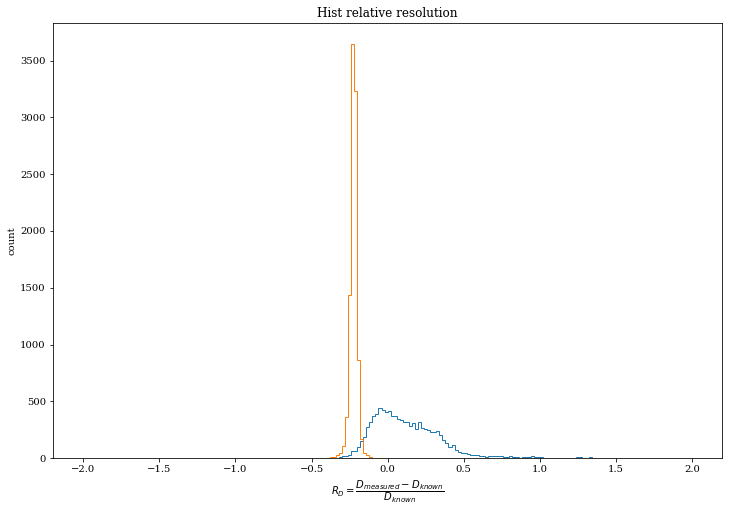

In [20]:
distrel_calib = (dmeas_calib - dknown) / dknown
distrel_interval_mean = distrel[(xmin <= distrel) & (distrel <= xmax)].mean()
distrel_interval_std = distrel[(xmin <= distrel) & (distrel <= xmax)].std(ddof=1)

distrel_calib_interval_mean = distrel_calib[(xmin <= distrel_calib) & (distrel_calib <= xmax)].mean()
distrel_calib_interval_std = distrel_calib[(xmin <= distrel_calib) & (distrel_calib <= xmax)].std(ddof=1)

hist_rel_calib = ax_rel.hist(distrel_calib, bins=Nbins, range=binning_RD, histtype='step', label='Calibration')

fig_rel

And fit that distribution with an extended gaussian:

In [21]:

entries, bin_edges, _ = hist_rel_calib
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
hist_x, hist_y = bin_centers, entries
hist_sy = np.sqrt(hist_y)

chi2_object = Chi2Regression(gauss_extended, hist_x[hist_y>0], hist_y[hist_y>0], hist_sy[hist_y>0])

minuit = Minuit(chi2_object, pedantic=False, mu=distrel_calib_interval_mean, sigma=distrel_calib_interval_std, N=10000)  
minuit.migrad()

fit_N, fit_mu, fit_sigma = minuit.args # the fitted values of the parameters
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

    
x_fit = np.linspace(-1, 1, 1000) # Create the x-axis for the plot of the fitted function
y_fit = gauss_extended(x_fit, fit_N, fit_mu, fit_sigma) # the fitted function

ax_rel.plot(x_fit, y_fit, '-', color='blue', label='Fit with Gaussian to calibrated data')



FCN = 329.78737196274756 
 TOTAL NCALL = 69 
 NCALLS = 69 
 
 
 EDM = 2.6879670196174827e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,N,9670.35,98.3372,,,,,No
1,mu,-0.223353,0.000211776,,,,,No
2,sigma,0.0206393,0.000192605,,,,,No


Fit value: N = 9670.35223 +/- 98.33724
Fit value: mu = -0.22335 +/- 0.00021
Fit value: sigma = 0.02064 +/- 0.00019


### Here we calculate the chi2 value of the fit and the number of non-empty bins:

In [22]:
chi2_val = 0
N_NotEmptyBin = 0
for x, y, sy in zip(hist_x, hist_y, hist_sy):
    if y > 0:
        f = gauss_extended(x, fit_N, fit_mu, fit_sigma) # calc the model value
        residual  = ( y-f ) / sy  # find the uncertainty-weighted residual
        chi2_val += residual**2  # the chi2-value is the squared residual
        N_NotEmptyBin += 1 # count the bin as non-empty since sy>0 (and thus y>0)
N_DOF = N_NotEmptyBin - len(minuit.args)

from scipy import stats
chi2_prob =  stats.chi2.sf(chi2_val, N_DOF) # The chi2 probability given N_DOF degrees of freedom

### Add this information on the plot and show the final updated figure:

In [23]:
d = {'Entries' : "{:d}".format(len(distrel_calib)), 
     'Mean'    : "{:.6f}".format(distrel_calib_interval_mean), 
     'STD Dev' : "{:.5f}".format(distrel_calib_interval_std), 
     'Chi2/ndf': "{:.3f} / {:.3f}".format(chi2_val, N_DOF), 
     'Prob'    : "{:.3f}".format(chi2_prob),
     'Constant': "{:.3f} +/- {:.3f}".format(minuit.values['N'], minuit.errors['N']),
     'Mu'      : "{:.6f} +/- {:.6f}".format(minuit.values['mu'], minuit.errors['mu']),
     'Sigma'   :"{:.5f} +/- {:.5f}".format(minuit.values['sigma'], minuit.errors['sigma'])}


ax_rel.text(0.02, 0.95, nice_string_output(d), family='monospace', 
        transform=ax_rel.transAxes, fontsize=12, verticalalignment='top');


ax_rel.set_xlim(-0.55,0.55)
ax_rel.set_xlabel('Relative precision (dmeas - dknown) / dknown')
ax_rel.set_ylabel('Frequency')
ax_rel.legend(loc='best')

fig_rel
print("  The initial and final resolutions are:  {:6.3f}  and  {:6.3f} \n".format(
        distrel_interval_std, distrel_calib_interval_std))

  The initial and final resolutions are:   0.269  and   0.025 



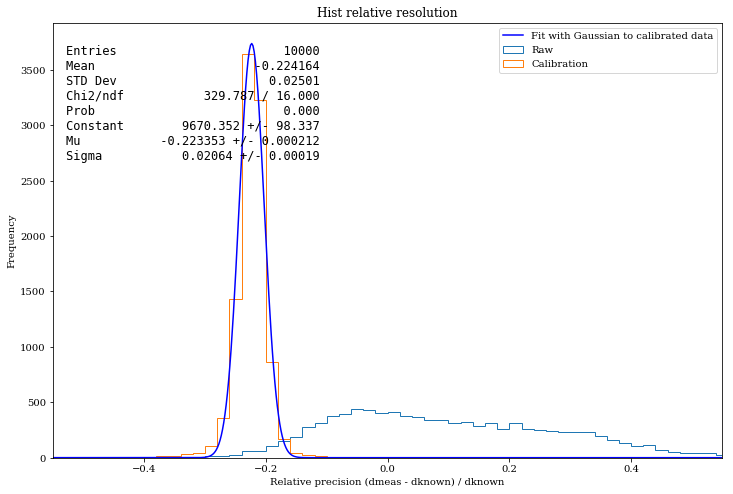

In [24]:
fig_rel

---

Seems like the calibrated distribution is still offset from zero. Let's make a final correction for this:

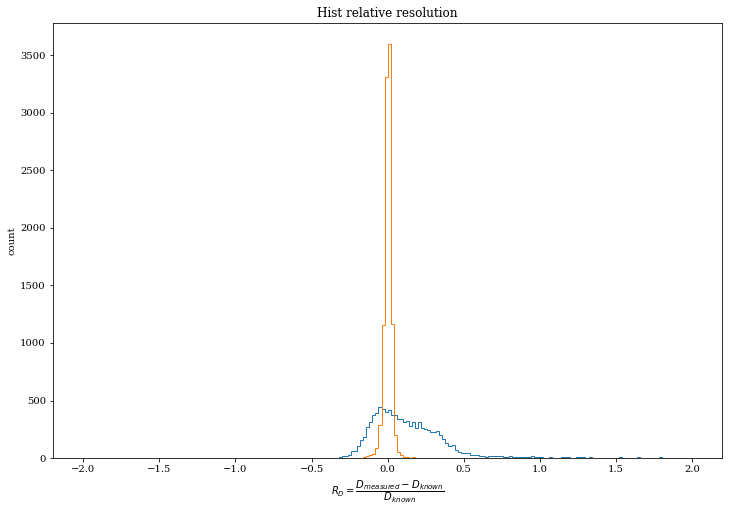

In [25]:
offset = minuit.values['mu']*dknown
dmeas_calib2 = dmeas_calib-offset
distrel_calib2 = (dmeas_calib2 - dknown) / dknown


fig_rel2, ax_rel2 = plt.subplots(figsize=(12, 8));
ax_rel2.set_title('Hist relative resolution');
Nbins = 200
xmin, xmax = -2,2
binwidth = (xmax-xmin) / Nbins

ax_rel2.hist(distrel, bins=Nbins, range=(xmin, xmax), histtype='step', label='Raw');
ax_rel2.hist(distrel_calib2, bins=Nbins, range=binning_RD, histtype='step', label='Calibration')
ax_rel2.set_xlabel(r'$R_{D} = \dfrac{D_{measured}-D_{known}}{D_{known}}$')
ax_rel2.set_ylabel('count')
fig_rel2

---

### __And that's it!__

Note that we can now check again the 2D histograms of $R_{D,calib}$ as a function of our initial parameters, and see that the correlations have gone away:

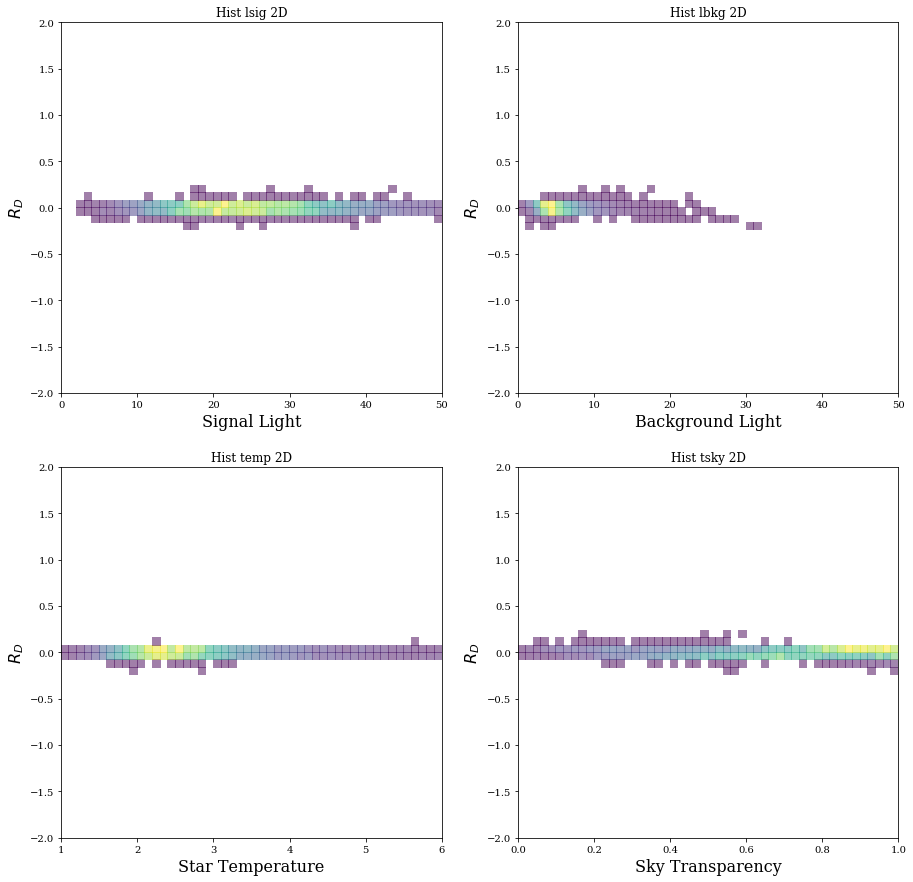

In [27]:
fig_2D_calib, axes_calib = plt.subplots(2,2,figsize=(15,15));

ax_lsig2Dc = axes_calib[0,0]
ax_lbkg2Dc = axes_calib[0,1]
ax_temp2Dc = axes_calib[1,0]
ax_tsky2Dc = axes_calib[1,1]

ax_lsig2Dc.set_title('Hist lsig 2D');
ax_lbkg2Dc.set_title('Hist lbkg 2D');
ax_temp2Dc.set_title('Hist temp 2D');
ax_tsky2Dc.set_title('Hist tsky 2D');

ax_lsig2Dc.hist2d(lsig, distrel_calib2, bins=50, range=[binning_lsig, binning_RD], cmin=1, alpha=0.5);
ax_lbkg2Dc.hist2d(lbkg, distrel_calib2, bins=50, range=[binning_lbkg, binning_RD], cmin=1, alpha=0.5);
ax_temp2Dc.hist2d(temp, distrel_calib2, bins=50, range=[binning_temp, binning_RD], cmin=1, alpha=0.5);
ax_tsky2Dc.hist2d(tsky, distrel_calib2, bins=50, range=[binning_tsky, binning_RD], cmin=1, alpha=0.5);

ax_lsig2Dc.set_ylabel(r'$R_{D}$',fontsize=16)
ax_lbkg2Dc.set_ylabel(r'$R_{D}$',fontsize=16)
ax_temp2Dc.set_ylabel(r'$R_{D}$',fontsize=16)
ax_tsky2Dc.set_ylabel(r'$R_{D}$',fontsize=16)

ax_lsig2Dc.set_xlabel(r'Signal Light',fontsize=16)
ax_lbkg2Dc.set_xlabel(r'Background Light',fontsize=16)
ax_temp2Dc.set_xlabel(r'Star Temperature',fontsize=16)
ax_tsky2Dc.set_xlabel(r'Sky Transparency',fontsize=16)

fig_2D_calib
